In [1]:
import three_desc_model_new as pyturb
import numpy as np
import pandas as pd
from cutoffs import Polynomial
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
dataset_full = pd.read_csv('all_dataset.csv', index_col=0)
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]
nl=pyturb.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)

/var/folders/gr/z6l2h7kd4136nf0xqdtls40w0000gn/T/ipykernel_1017/4064572797.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dataset_full["IDnum"]=pd.Series()


In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 8])
    plt.xlabel('Epoch')
    plt.ylabel('Error [ref_wind_speed]')
    plt.legend()
    plt.grid(True)

In [3]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [31]:
Gs = pyturb.make_symmetry_functions(turbines=symbol, type='G2',
                                    etas=np.linspace(1,10,5),
                                    offsets=[0.46])
Gs += pyturb.make_symmetry_functions(turbines=symbol, type='G4',
                                     etas=np.linspace(1,10,5),
                                     zetas=np.linspace(1,3,3),
                                     gammas=[-1,1])
Gs += pyturb.make_symmetry_functions(turbines=symbol, type='G6',
                                     etas=np.linspace(1,10,5),
                                     zetas=np.linspace(0,3,5),
                                     gammas=[-1,1])

In [32]:
Gs

[{'type': 'G2', 'turbine': 'Siemens', 'eta': 1.0, 'offset': 0.46},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 3.25, 'offset': 0.46},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 5.5, 'offset': 0.46},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 7.75, 'offset': 0.46},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 10.0, 'offset': 0.46},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': -1, 'zeta': 1.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 1, 'zeta': 1.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': -1, 'zeta': 2.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 1, 'zeta': 2.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': -1, 'zeta': 3.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 1, 'zeta': 3.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.25, 'gamma': -1, 'zeta': 1.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.25, 'gamma': 1, 'zeta': 1.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.2

In [33]:
#Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":7.83091952, "offset": 1.},
#                  {"type":"G4", "turbine":"Siemens","eta":1.91278235, "gamma":4., "zeta": 1.0},
#                  {"type":"G6", "turbine":"Siemens","eta":0.8768927, "gamma": 0.5, "zeta": 1.0}
#                 ]}
finpr=pyturb.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, len(Gs)))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset)

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()
all_features = dataset.copy()

train_labels = train_features.iloc[:,-1]
test_labels = test_features.iloc[:,-1]
all_labels = all_features.iloc[:,-1]

In [34]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [35]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 86)               173       
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 64)                5568      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                      

In [36]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=120)

CPU times: user 8.22 s, sys: 1.62 s, total: 9.84 s
Wall time: 5.87 s


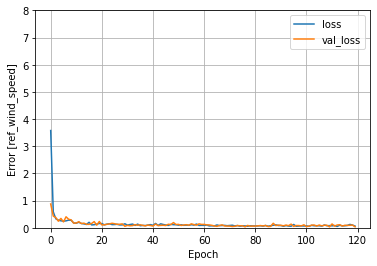

In [37]:
plot_loss(history)

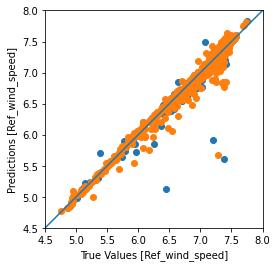

In [38]:
test_predictions = dnn_model.predict(test_features).flatten()
train_predictions = dnn_model.predict(train_features).flatten()
#test_predictions_0 = dnn_model.predict(test_features["Fingerprint(G2)"]==0).flatten()
#train_predictions_0 = dnn_model.predict(train_features["Fingerprint(G2)"]==0).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)#,c=test_features["Fingerprint(G2)"])
plt.scatter(train_labels, train_predictions)#,c=train_features["Fingerprint(G2)"])
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
#cbar=plt.colorbar()
#cbar.set_label('Fingerprint(G2)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

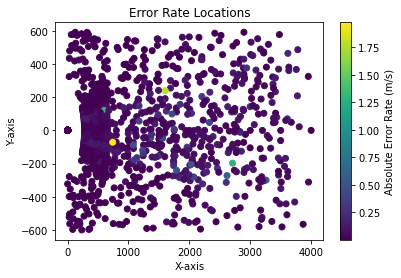

In [39]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

In [ ]:
arg=np.argsort(error_all)
error_all[arg]

In [ ]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[arg[-20:],0], dataset_pos[arg[-20:],1],c=error_all[arg[-20:]])
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()

In [ ]:
dataset_pos[523]
all_predictions[523]
#all_labels[523]

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model.save('dnn_model')

In [ ]:
print(min(error),max(error))

In [ ]:
arg[30:]

In [ ]:
error_all[577:582]

In [ ]:
import matplotlib.cm as cm
plt.scatter(dataset['Fingerprint(G4)'],dataset['Fingerprint(G2)'], c=dataset['Ref_Wind_Speed'], s=10, cmap=cm.bwr)
cbar= plt.colorbar()
plt.xlabel('Fingerprint(G4)')
plt.ylabel('Fingerprint(G2)')
plt.show()

In [ ]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
import numpy
from mayavi.mlab import *

def test_points3d():


    x = all_features["Fingerprint(G2)"]
    y = all_features["Fingerprint(G4)"]
    z = all_features["Fingerprint(G6)"]
    s = error_all
    colorbar(orientation='vertical')
    xlabel('Fingerprint(G2)')
    ylabel('Fingerprint(G4)')
    zlabel('Fingerprint(G6)')
    return points3d(x, y, z, s, colormap="blue-red", scale_factor=0.05)
test_points3d()
#colorbar(object=all_labels, title="Points in Mayavi")
#view()
show()